In [34]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [12, 7]

Let's read the data in and see what we got!

In [35]:
# read CF34 deck into a dataframe
df_CF34 = pd.read_csv("CF34_deck_v2.csv", header=0)

Select a parameter for right hand plot:

In [36]:
# simple plotting function to facilitate many plots!
def quick_plot(Machs, alt_bracket, PC_bracket, rh_plot_parameter, df):
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('CF34-10 Deck')
    
    for Mach in Machs:
        #print(Mach)
        Mach_bracket = [Mach-0.01, Mach+0.01]
    
        # filter dataframe:
        filtered_df = df[(df.alt>=alt_bracket[0]) & (df.alt<=alt_bracket[1]) & \
                         (df.MN>=Mach_bracket[0]) & (df.MN<=Mach_bracket[1]) & \
                         (df.PC>=PC_bracket[0]) & (df.PC<=PC_bracket[1])]
        
        x1 = filtered_df['alt'].to_numpy()
        y1 = filtered_df['Fn'].to_numpy()
        x2 = x1
        y2 = filtered_df[rh_plot_parameter].to_numpy()
        
        
        ax1.plot(x1, y1)
        ax2.plot(x2, y2, label=f'M={Mach:0.1f}')
    
    
    ax1.set_title('Thrust')
    ax1.set(xlabel='Altitude', ylabel='T [lbf]')
    ax1.grid(alpha=0.2)
    
    
    ax2.set_title(rh_plot_parameter)
    ax2.set(xlabel='Altitude', ylabel=rh_plot_parameter)
    ax2.grid(alpha=0.2)
    ax2.legend(title='Mach:', loc='lower right')
    fig.show()

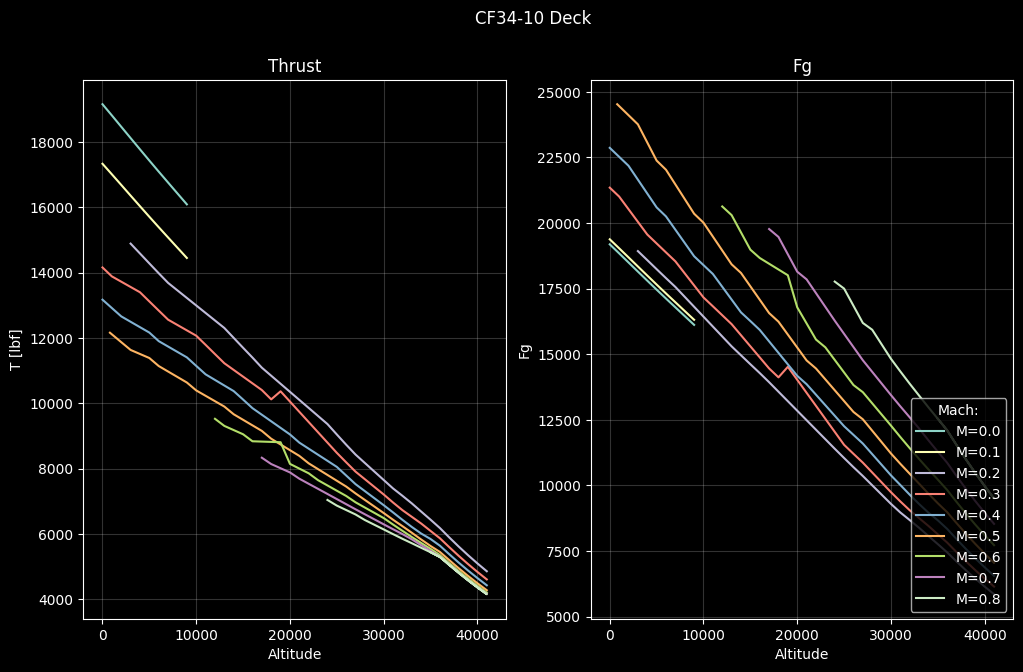

In [37]:
alt_bracket = [0, 42000] #ft
PC_bracket = [1.0, 1.0] # % power
Machs = np.arange(0, 0.9, 0.1)
RH_graph = 'Fg'
quick_plot(Machs, alt_bracket, PC_bracket, RH_graph, df_CF34)

Deck Evaluation

We can clearly see that there is something going on.

The bumps in thrust are not expected and the reason needs to be investigated. 

We can try to find where this comes from, where it originates...

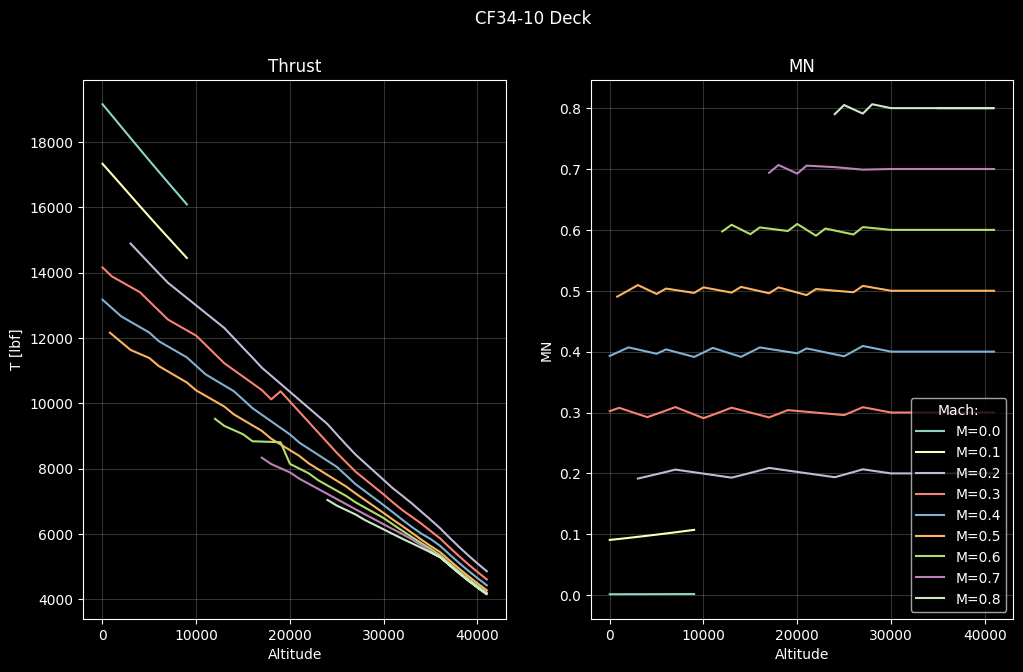

In [38]:
# plot Mach number...
RH_graph = 'MN'
quick_plot(Machs, alt_bracket, PC_bracket, RH_graph, df_CF34)

Finer data
To investigate the origin for this, the best way is to plot each of the parameters we captured in our dataframe/deck.

But we have a slight problem: our deck has data that at lower altitude where Mach number is not constant. We can see this on the wavy lines of the Mach plot above.

My first thought was to re-run the deck focusing on finding the "problem" altitude, but with much higher resolution.

Zoomed in flight envelope: **Mach = 0.75, Altitudes = 1000 to 35000ft every 250ft and PC=1.0 fixed**

I reran pyCycle for the CF34 deck and also for the original high bypass turbofan stock pyCycle example

In [39]:
# read dataframes that contain only throttle at 1.0 (max)
# and high resolution data

# CF34 high res specific data
df_CF34_19k = pd.read_csv("CF34_deck_19k.csv", header=0)

# original pyCycle HBTF example data, high resolution
df_pyCycle_HBTF = pd.read_csv("pycycle_HBTF_deck_19k.csv", header=0)

In [40]:
# define altitude and Mach brackets to filter data for plotting

alt_brackets = [[2000, 40000], [17500, 20500]] # two brackets, first for complete graph, second for zoomed-in
Mach_bracket = [0.7, 0.8]

In [54]:
# filter data from each of our dataframes
dataframes = [df_CF34_19k, df_pyCycle_HBTF]
altitudes = []
thrust = []
for df in dataframes:
    for alt_bracket in alt_brackets:
        mydf = df[(df.alt>alt_bracket[0]) & (df.alt<alt_bracket[1]) & \
                 (df.MN>Mach_bracket[0]) & (df.MN<Mach_bracket[1])]
        thrust.append(mydf['Fn'].to_numpy())
        altitudes.append(mydf['alt'].to_numpy())

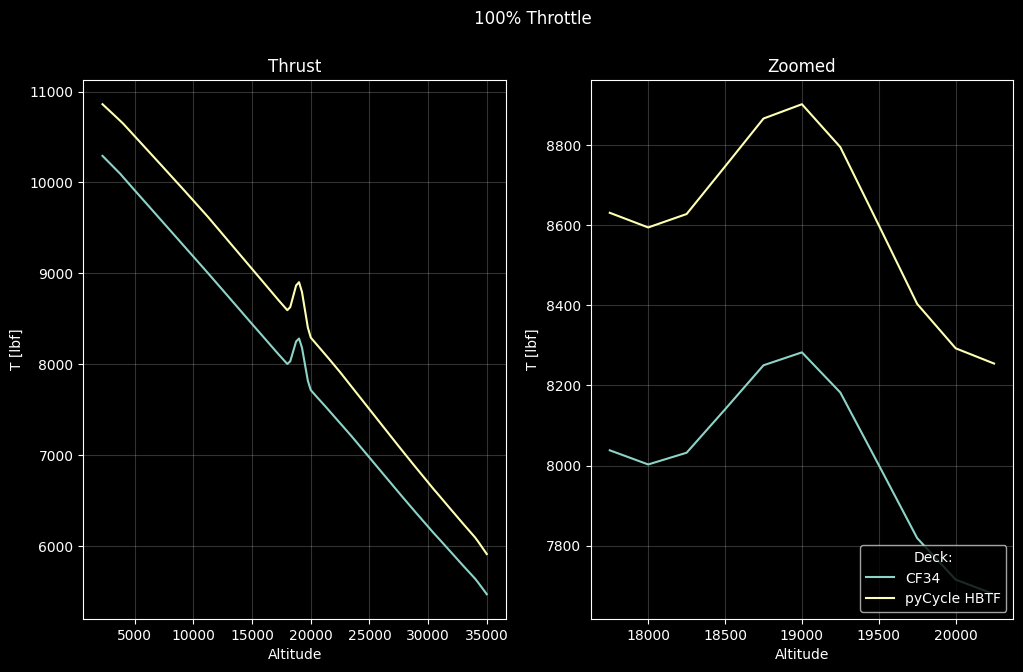

In [55]:
# plot the data for both Decks

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('100% Throttle')

ax1.plot(altitudes[0], thrust[0])
ax1.plot(altitudes[2], thrust[2])
ax2.plot(altitudes[1], thrust[1], label='CF34')
ax2.plot(altitudes[3], thrust[3], label='pyCycle HBTF')

ax1.set_title('Thrust')
ax1.set(xlabel='Altitude', ylabel='T [lbf]')
ax1.grid(alpha=0.2)


ax2.set_title('Zoomed')
ax2.set(xlabel='Altitude', ylabel='T [lbf]')
ax2.grid(alpha=0.2)
ax2.legend(title='Deck:', loc='lower right')
fig.show()

Anomaly at 19000ft
Now we can clearly see tha the problem lies in the 19000ft data.

To investigate this further we could plot all the parameters we have available in our deck.

Two paths here:
1. run pyCycle again with constant Mach numbers
2. plot interpolated data

We're better off interpolating our data. It will be faster (that is what we were going to do anyways!)

Let's develop our LUT routine here, we can later transfer it to its own file

# interpolation

In [10]:
def get_bracket(target:float, val_list:list)->float:
    '''
    given a target value, find neighbouring lower and higher
    values from a list. Ex: target = 5, list = [1,2,3,4,5,6,7]
    returns low_val=4, high_val=6
    note: the val_list maybe unordered.
    inputs:
        target: value
        val_list: list of values (maybe out-of-order)
    outputs:
        lower value, higher value
    '''
    
    highs = []
    lows = []
    
    for x in val_list:
        if x >= target:
            highs.append(x)
        else:
            lows.append(x)
    
    if highs: # if this list is not empty, we get the min
        high_val = min(highs)
    else: #otherwise it means we are on the edge.
        high_val = max(val_list)
    
    if lows: # same idea
        low_val = max(lows)
    else:
        low_val = min(val_list)
    
    return low_val, high_val


In [11]:
def linear_interp(x:float, x2:float, x1:float, y2:float, y1:float)->float:
    '''
    simplest form of linear interpolation between 2 data points
    inputs. NOTE INPUT VARIABLES POSITIONS!
        x: value to be interpolated at
        x2, X1: x-coordinates of first and second data points
        y1, y2: y-coordinates of first and second data points
    returns
        interpolated value
    '''
    m = (y2 - y1) / (x2 - x1)
    x0 = y1 - m * x1
    
    return m * x + x0

In [12]:
def adjust_limits(val:float, val_list:list)->float:
    '''
    This function is used to adjust the interpolation limits
    Given a value and a list (ordered)
    If values out-of-range, set 2 closest values
    this allows for linear interpolation (capture the slope at the ends of table)
    '''
    if abs(val - val_list[0]) > abs(val - val_list[-1]): # we are at the high end
        # get 2 highest values
        high_val = val_list[-1]
        low_val = val_list[-2]
    else: # we are at the low end
        # get 2 lowest values
        high_val = val_list[1]
        low_val = val_list[0]
        
    return low_val, high_val

In [13]:
def interp_altMNPC(Hp:float, MN:float, PC:float, df:pd.DataFrame)->dict:
    '''
    This function will take a pandas dataframe from our Deck and return a linearly interpolated
    dictionary for each "key" in the dataframe.
    
    inputs
        Hp: altitude (in ft)
        MN: Mach number
        PC: power setting (float between 1 and 0)
    retunrs
        res: dictionary with interpolated values for each key in the dataframe
    '''
    # let's make a list of altitudes and Mach numbers we have in the deck data so that we can know
    # where we can interpolate

    # first create a list of the unique altitudes
    # if there are duplicate altitudes, the first occurence will be chosen
    alts = df['alt'].unique()

    # then, for each altitude, create a list of MNs... let's create a dictionary
    alt_MN = {}
    for alt in alts:
        alt_MN[alt] = df[df['alt'] == alt]['MN'].unique().tolist()

    # likewise, a list of PCs
    # here we check at the first altitude and Mach=0 only. Sufficient.
    PCs = df[(df['alt'] == df['alt'][0]) & (df['MN'] == df['MN'][0])]['PC'].unique().tolist()

    # capture the column names in a list to make our life easier when we are dealing with numpy arrays
    col_names = df.columns.to_list()
        
        
    ###############################
    #   DEFINE THE BACKETS        #
    ###############################
    # the idea here is to find the data to interpolate from
    # it is all in the database, we just need to filter it.
    # we will find the altitude bracket
    # then the Mach bracket
    # and finally the PC bracket

    # this dictionary will hold the altitude and Mach barckets
    pt_bracket = {'low': {'alt':0, 'M_low':0, 'M_high':0}, 'high': {'alt':0, 'M_low':0, 'M_high':0}}  # initialize to zero
    
    pt_bracket['low']['alt'], pt_bracket['high']['alt'] = get_bracket(Hp, alt_MN.keys()) # populate altitudes
    if pt_bracket['low']['alt'] == pt_bracket['high']['alt']: # check if we are out-of-range
        # dump keys into list
        alt_list = alt_MN.keys() # remember each key is an altitude
        # sort it
        alt_list = sorted(alt_list)
        # adjust the low and high values to the 2 nearest points
        pt_bracket['low']['alt'], pt_bracket['high']['alt'] = adjust_limits(Hp, alt_list)


    # now, Mach
    # we will have 'low altitude' x 'M_low'
    #              'low altitude' x 'M_high'
    #              'high altitude' x 'M_low'
    #              'high altitude' x 'M_high'
    for lh in ['low', 'high']:
        pt_bracket[lh]['M_low'], pt_bracket[lh]['M_high'] = get_bracket(MN, alt_MN[pt_bracket[lh]['alt']]) # populate MNs for each alt

        if pt_bracket[lh]['M_low'] == pt_bracket[lh]['M_high']: # check if we are out-of-range
        # dump keys into list
            MN_list = []
            for MN_for_alt in alt_MN[pt_bracket[lh]['alt']]: # remember each key is an altitude
                MN_list.append(MN_for_alt)
            # sort it
            MN_list = sorted(MN_list)
            pt_bracket[lh]['M_low'], pt_bracket[lh]['M_high'] = adjust_limits(MN, MN_list)


    # finally, the PCs
    PC_low, PC_high = get_bracket(PC, PCs)
    if PC_low == PC_high: # check if we are out-of-range
        PC_low, PC_high = adjust_limits(PC, sorted(PCs))
    ############################### 


    ###############################
    #   INTERPOLATE               #
    ###############################

    
    interp_pts = [] # temporary placeholder for interpolation points converted to numpy from dataframe
    # now we dump our data to numpy arrays to facilitate the interpolation math
    # at this point, we are still carrying all PCs
    if pt_bracket['low']['alt'] != pt_bracket['high']['alt']:
        interp_pts.append(df.query(f"alt == {pt_bracket['high']['alt']} and (MN == {pt_bracket['high']['M_high']})").to_numpy())
        interp_pts.append(df.query(f"alt == {pt_bracket['high']['alt']} and (MN == {pt_bracket['high']['M_low']})").to_numpy())
        interp_pts.append(df.query(f"alt == {pt_bracket['low']['alt']} and (MN == {pt_bracket['low']['M_high']})").to_numpy())
        interp_pts.append(df.query(f"alt == {pt_bracket['low']['alt']} and (MN == {pt_bracket['low']['M_low']})").to_numpy())
    else:
        print('error finding brackets!')
    
    #interpolation - linear classic
    temp_pts = [] # temporary placeholder for intermmedeate interpolation points

    # first, interpolate PCs
    x2 = PC_high
    x1 = PC_low
    for i in range(4):
        y2 = interp_pts[i][np.where(interp_pts[i][:,col_names.index('PC')] == x2)]
        y1 = interp_pts[i][np.where(interp_pts[i][:,col_names.index('PC')] == x1)]
        temp_pts.append(linear_interp(PC, x2, x1, y2, y1))

    # then, interpolate Mach number
    temp_pts2 = []

    for idx, i in enumerate(['high', 'low']):
        x2 = pt_bracket[i]['M_high']
        x1= pt_bracket[i]['M_low']
        y2 = temp_pts[(2*idx)] #0, 2
        y1 = temp_pts[(2*idx)+1] #1, 3
        temp_pts2.append(linear_interp(MN, x2, x1, y2, y1))

    # last, interpolate altitudes
    x2 = pt_bracket['high']['alt']
    x1= pt_bracket['low']['alt']
    y2 = temp_pts2[0]
    y1 = temp_pts2[1]
    interp_data = linear_interp(Hp, x2, x1, y2, y1)

    # now, we package our output in a dictionary:
    res = {}
    for idx, col in enumerate(col_names):
        res[col] = interp_data[0][idx]
        
    return res

In [14]:
# quick check
MN = 0.3
alt = 18000
PC = 1.0
res = interp_altMNPC(alt, MN, PC, df_CF34)
print(f'MN={MN}')
print(f'alt={alt}')
print(f'PC={PC}')
print(res['Fn'])

MN=0.3
alt=18000
PC=1.0
10105.807988146906


Let's plot some interpolated data:

In [15]:
# interpolate over the full flight envelope, for full throttle
# this cell takes some time to run...
Machs = np.arange(0, 1.0, 0.1)
altitudes = np.arange(0, 40000, 100)


PC = 1.0
idata = {}
for Mach in Machs:
    temp_pts = []
    for alt in altitudes:
        temp_point = interp_altMNPC(alt, Mach, PC, df_CF34)
        temp_pts.append(temp_point)
    idata[Mach] = temp_pts
        

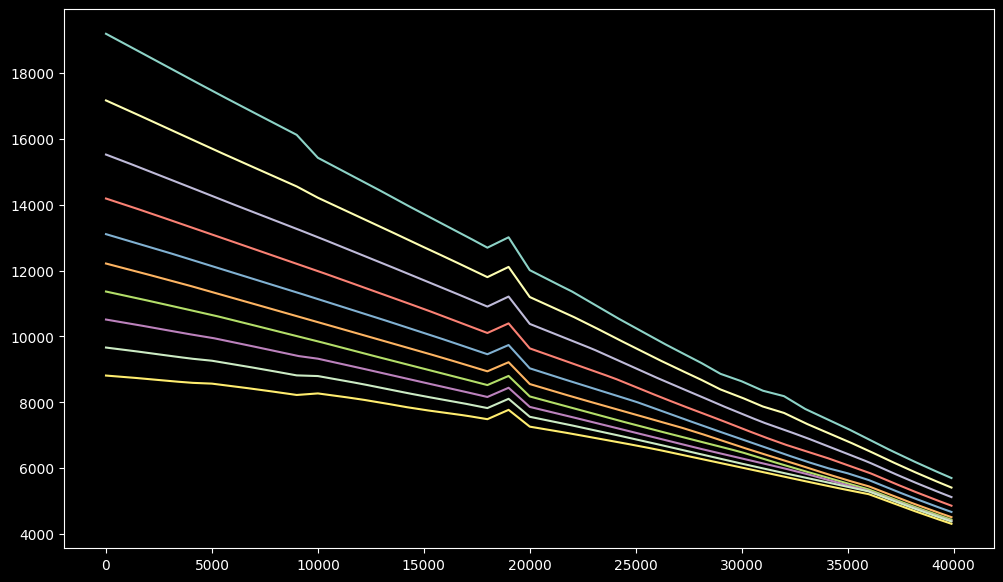

In [17]:
# quick plot
plot_key = 'Fn' # this is the parameter to be ploted on the right-hand side plot
for Mach in Machs:
    temp = [i[plot_key] for i in idata[Mach]]
    plt.plot(altitudes, temp)
plt.show()


Now, we can clearly see the problem area so let's plot more data.

In [18]:
def deckplot(altitudes, Machs, PC, p2_key, df):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('CF34-10 Deck')

    
    idata = {}
    for Mach in Machs:
        temp = []
        for alt in altitudes:
            temp.append(interp_altMNPC(alt, Mach, PC, df))
        idata[Mach] = temp
    
        # filter dataframe:

    y1 = []
    y2 = []
    for Mach in Machs:
        for i in idata[Mach]:
            y1.append(i['Fn'])
            y2.append(i[p2_key])
        ax1.plot(altitudes, y1)
        ax2.plot(altitudes, y2, label=f'M={Mach:0.1f}')
        y1 = []
        y2 = []  
    
    ax1.set_title('Thrust')
    ax1.set(xlabel='Altitude', ylabel='T [lbf]')
    ax1.grid(alpha=0.2)
    
    
    ax2.set_title(p2_key)
    ax2.set(xlabel='Altitude', ylabel=p2_key)
    ax2.grid(alpha=0.2)
    ax2.legend(title='Mach:', loc='lower right')
    fig.show()
    
    return fig

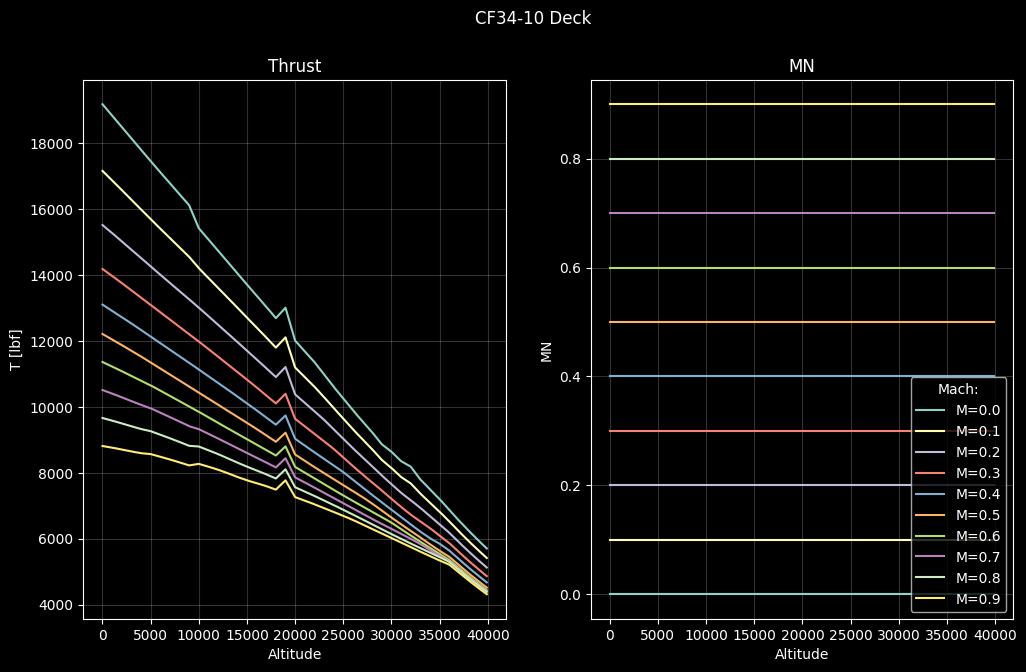

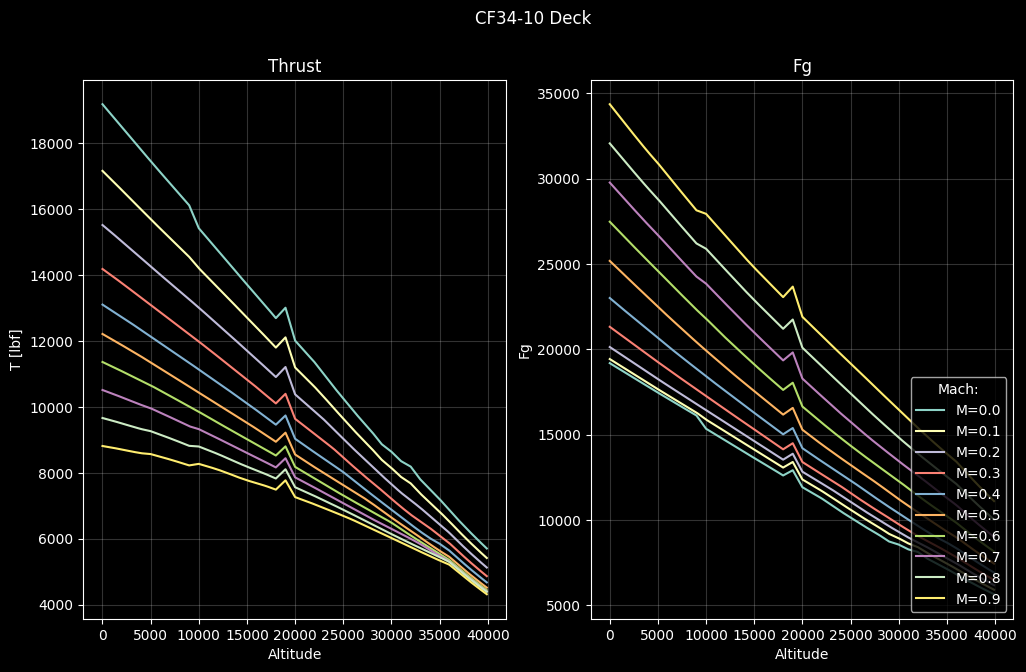

In [19]:
# quick test
param_list = ['MN', 'Fg']
figures = [deckplot(altitudes, Machs, 1.0, p, df_CF34) for p in param_list]

In [ ]:
# full set of plots
# this cell tales a long time to run...
param_list = df_CF34.columns.to_list() # select all parameters available in our deck
figures = [deckplot(altitudes, Machs, 1.0, p, df_CF34) for p in param_list]


Because we will have many figures, instead of showing in the notebook, let's save to disk



In [ ]:
for idx, f in enumerate(figures):
    f.savefig(f'fig_{idx}_{param_list[idx]}.png', format='png')

We can now scroll through the figures and do some thinking...

# the solution

Let's filter out the 19000ft data

In [20]:
clean_df = df_CF34[(df_CF34.alt<18999) | (df_CF34.alt>20001)]

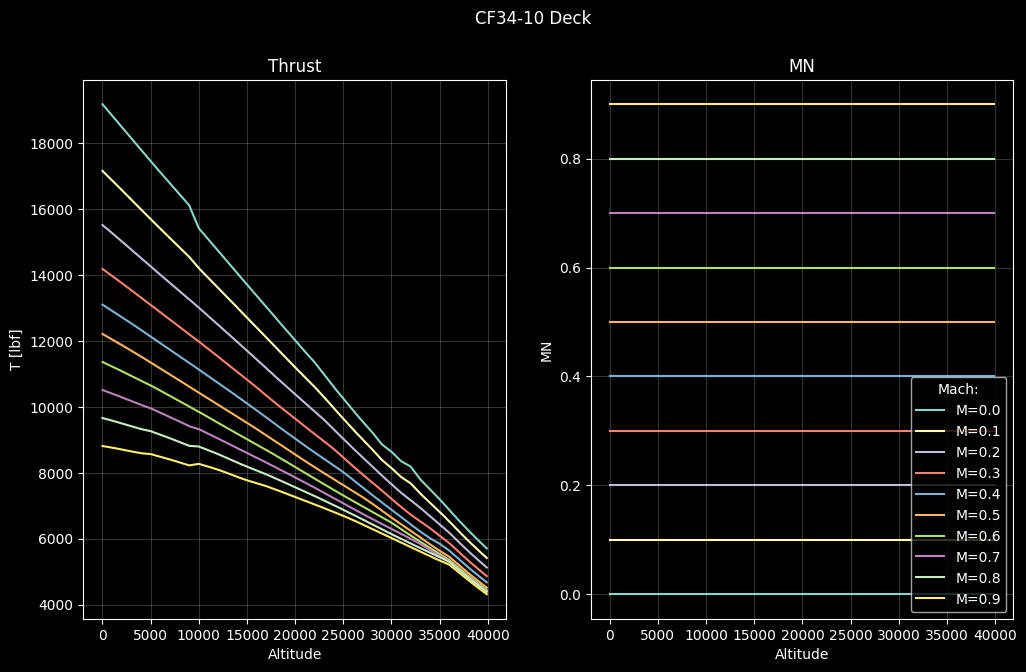

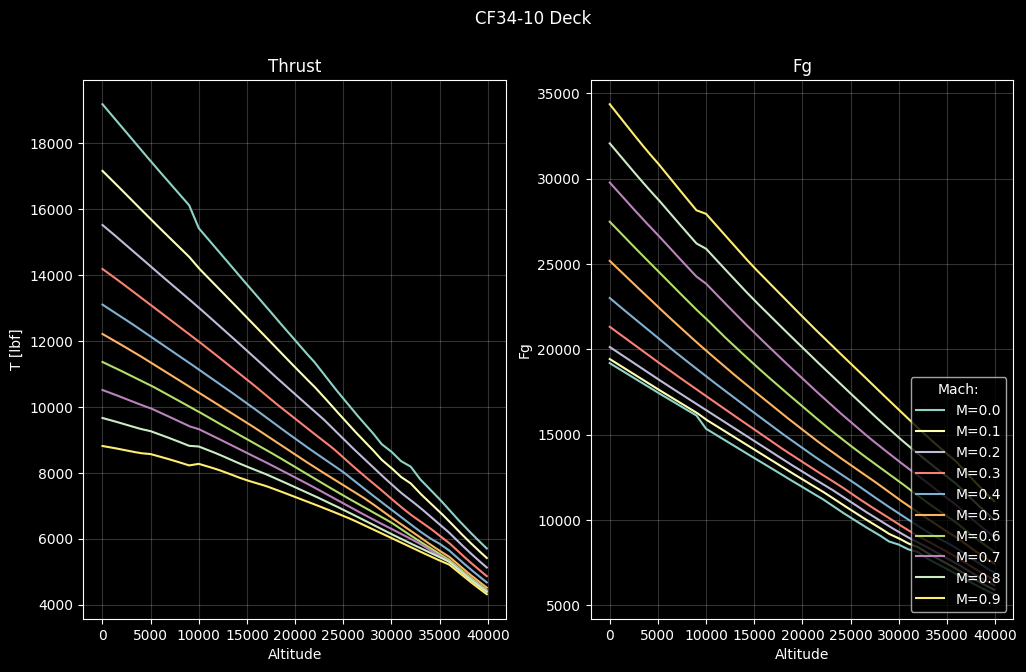

In [21]:
# quick test
param_list = ['MN', 'Fg']
figures = [deckplot(altitudes, Machs, 1.0, p, clean_df) for p in param_list]

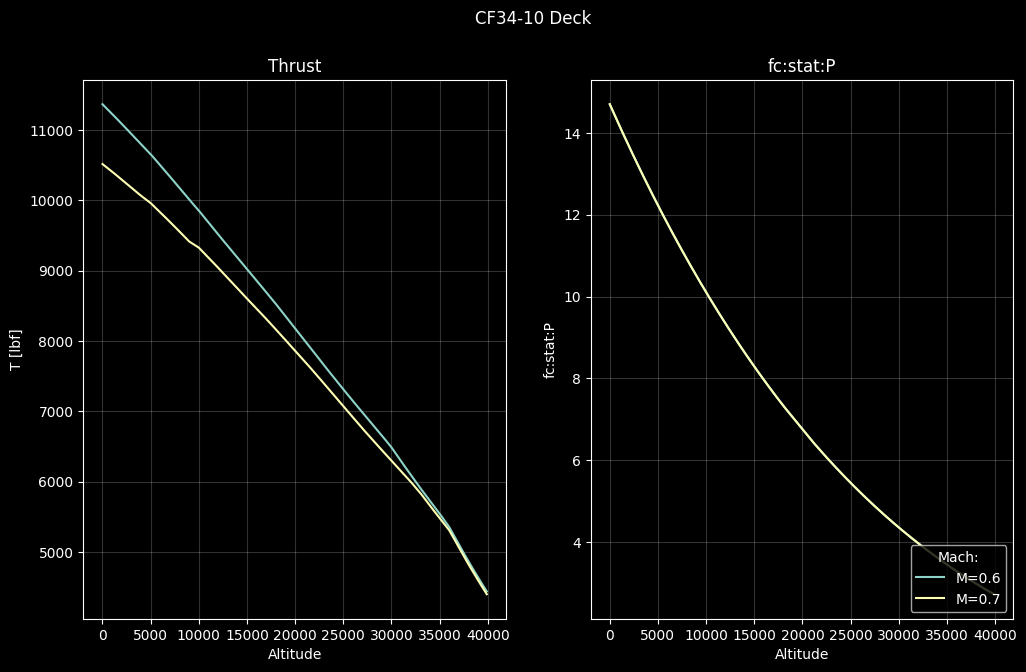

In [22]:
# quick check
Machs2 = [0.6, 0.7]
param_list2 = ['fc:stat:P']
figures = [deckplot(altitudes, Machs2, 1.0, p, clean_df) for p in param_list2]

Although far from ideal, this gives us an approxiamte solution to use the CF34-10 deck while further investigation is done.

interpolation check:
1. extremes
2. out-of-extremes
3. speed test

In [23]:
# checking interpolation extremes
print('Low speed, low altitude:')
MN = 0.0
alt = 0
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoint: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

Low speed, low altitude:
MN=0.0, alt=0, PC=1.0
interpolated thrust: 19186 lbf, closest thruth datapoint: [19153.27783714] lbf


In [24]:
print('Low speed, invalid altitude:')
MN = 0.0
alt = -10
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoint: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

Low speed, invalid altitude:
MN=0.0, alt=-10, PC=1.0
interpolated thrust: 19190 lbf, closest thruth datapoint: [] lbf


In [25]:
print('High speed, low altitude:')
MN = 0.5
alt = 0
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoint: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

High speed, low altitude:
MN=0.5, alt=0, PC=1.0
interpolated thrust: 12214 lbf, closest thruth datapoint: [12351.94396429] lbf


In [26]:
print('extrapolated speed, low altitude:')
MN = 0.9
alt = 0
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoint: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

extrapolated speed, low altitude:
MN=0.9, alt=0, PC=1.0
interpolated thrust: 8814 lbf, closest thruth datapoint: [] lbf


In [27]:
print('mid-envelope:')
MN = 0.78
alt = 35000
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoints: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

mid-envelope:
MN=0.78, alt=35000, PC=1.0
interpolated thrust: 5461 lbf, closest thruth datapoints: [5441.91315988 5441.91315988 5465.64102357] lbf


In [28]:
print('High speed, high altitude:')
MN = 0.82
alt = 41000
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoints: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

High speed, high altitude:
MN=0.82, alt=41000, PC=1.0
interpolated thrust: 4145 lbf, closest thruth datapoints: [4157.28048855 4123.09999423 4141.72941417 4157.28048867] lbf


In [29]:
print('High speed, invalid altitude:')
MN = 0.82
alt = 44000
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoints: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

High speed, invalid altitude:
MN=0.82, alt=44000, PC=1.0
interpolated thrust: 3519 lbf, closest thruth datapoints: [] lbf


In [30]:
print('invalid speed, high altitude:')
MN = 0.93
alt = 41000
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf, closest thruth datapoints: {clean_df[(clean_df['alt']==alt) & 
                        (clean_df['MN']<=MN+0.03) & 
                        (clean_df['MN']>=MN-0.03) & 
                        (clean_df['PC']==PC)]['Fn'].to_numpy()} lbf')

invalid speed, high altitude:
MN=0.93, alt=41000, PC=1.0
interpolated thrust: 4064 lbf, closest thruth datapoints: [] lbf


API speed test time!

In [31]:
import timeit

In [32]:
niter = 1000 # number of runs to average our timing
MN = 0.82
alt = 41000
PC = 1.0
res = interp_altMNPC(alt, MN, PC, clean_df)
print(f'MN={MN}, alt={alt}, PC={PC}')
print(f'interpolated thrust: {res['Fn']:.0f} lbf')
API_total_time = timeit.timeit(lambda: interp_altMNPC(alt, MN, PC, clean_df)['Fn'], number=niter)
print(f'{niter} calls: {API_total_time:.3f} seconds, equates to {1/(API_total_time/niter):.1f}Hz')

MN=0.82, alt=41000, PC=1.0
interpolated thrust: 4145 lbf
1000 calls: 46.076 seconds, equates to 21.7Hz
